### Flowchart 
https://app.diagrams.net/#G1cV535YSmnTYzbPTn92zdyRegWAwrhzeD

In [1]:
# Import packages

import cv2
import open3d as o3d
from open3d.web_visualizer import draw
import time
import json
import numpy as np
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


### Stream camera function is responsible for acquiring depth and rgb images.
The function is prepared for Intel Realsense cameras. All parameters of stream are configurable via JSON file. We recommend setting depth and rgb images resolution to the same values. What is more, make sure your camera is aligning depth with color

#### Input:
* config_filename - .json file 
* number_of_images - how many rgb-and-depth-pairs should be acquired

#### Output:
* data:
    - color - a list of color images
    - depth - a list of depth images
* camera information:
    - fx - focal length x
    - fy - focal length y
    - cx - optical center x
    - cy - optical center y
    - width - image width
    - height - image height

In [2]:
def stream_camera(config_filename, number_of_images=1):
    # Load JSON with configuration
    with open(config_filename) as cf:
        rs_cfg = o3d.t.io.RealSenseSensorConfig(json.load(cf))

    # Initialize device and get metadata
    rscam = o3d.t.io.RealSenseSensor()
    rscam.init_sensor(rs_cfg)
    rgbd_metadata = rscam.get_metadata()

    # Get intrinsic parameters from metadata
    fx = rgbd_metadata.intrinsics.intrinsic_matrix[0][0]
    fy = rgbd_metadata.intrinsics.intrinsic_matrix[1][1]
    ppx = rgbd_metadata.intrinsics.intrinsic_matrix[0][2]
    ppy = rgbd_metadata.intrinsics.intrinsic_matrix[1][2]
    height = rgbd_metadata.height
    width = rgbd_metadata.width

    # Start acquiring images
    rscam.start_capture(start_record=True)
    print('Waiting 2 seconds for camera to start...')
    time.sleep(2)
    print('Capturing frames')
    
    # Acquire number_of_images RGB and Depth frames
    camera_rgb_images = []
    camera_depth_images = []
    for _ in range(number_of_images):
        rgbd_frame = rscam.capture_frame(align_depth_to_color=True)
        color = rgbd_frame.color
        depth = rgbd_frame.depth

        camera_rgb_images.append(color)
        camera_depth_images.append(depth)

        # color_tensor = o3d.core.Tensor(color, dtype=o3d.core.Dtype.UInt8)
        # depth_tensor = o3d.core.Tensor(depth_filtered, dtype=o3d.core.Dtype.UInt16)
        # color_image = o3d.t.geometry.Image(color_tensor)
        # depth_image = o3d.t.geometry.Image(depth_tensor)
        # rgbd_frame = o3d.t.geometry.RGBDImage(color_image, depth_image)


    # Stop device
    rscam.stop_capture()

    # Return results
    return {"color":camera_rgb_images, "depth": camera_depth_images}, {"fx": fx, "fy": fy, "cx": ppx, "cy": ppy, "height": height, "width": width}

### Truncate depth values to zero if value is distance is greater than threshold
This function provides numerical stability. It may happen, that some pixels of depth images have significantly larger values than others. In such a case, scaling for visualization and filtering may give incorrect results.
In our setup, we are sure, that any pixel should be greater than 2000 (it means 2m).

#### Input
* depth_frame - depth image in UINT16 format (open3d.t.geometry.Image)
* d - threshold distance (in millimeters)

#### Output
* truncate depth frame (open3d.t.geometry.Image)

In [3]:
def trunc_depth(depth_frame, d):
    arr_img = np.asarray(depth_frame.to_legacy_image())
    arr_img[arr_img >= d] = 0
    tensor = o3d.core.Tensor(arr_img)
    image = o3d.t.geometry.Image(tensor)
    return image

### Bilateral filter function applies bilateral filter of depth image which smoothes it while preserving edges
A bilateral filter is a non-linear, edge-preserving, and noise-reducing smoothing filter for images. It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels. This weight can be based on a Gaussian distribution. Crucially, the weights depend not only on Euclidean distance of pixels, but also on the radiometric differences (e.g., range differences, such as color intensity, depth distance, etc.). This preserves sharp edges.

#### Input:
* depth_frame - depth image in UINT16 format (open3d.t.geometry.Image)
* d - diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace
* sigma_color - filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color
* sigma_space - filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor ). When d>0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is proportional to sigmaSpace

#### Output:
* depth image - filtered image (open3d.t.geometry.Image)

In [4]:
def bilateral_filter(depth_frame, d, sigma_color, sigma_space):
    arr_img = np.asarray(depth_frame.to_legacy_image()).astype(np.float32)
    arr_filtered = cv2.bilateralFilter(arr_img, d, sigma_color, sigma_space)
    tensor = o3d.core.Tensor(arr_filtered.astype(np.uint16))
    image = o3d.t.geometry.Image(tensor)
    return image

### Joint bilateral filter is more advanced version of bilateral filter which uses color image as a guide for filtering
Joint bilateral filter is a variant of the bilateral filter that
decouples the notion of edges to preserve from the image to smooth. Given an image I, the
joint bilateral filter smoothes I while preserving the edges of a second image E. In practice,
the range weight is computed using E instead of I.
#### Input:
* color - color image in UINT16 format (open3d.t.geometry.Image)
* depth - depth image in UINT16 format (open3d.t.geometry.Image)
* d - diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace
* sigma_color - filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color
* sigma_space - filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigma_color). When d>0, it specifies the neighborhood size regardless of sigma_space. Otherwise, d is proportional to sigmaSpace

#### Output:
* depth image - filtered image (open3d.t.geometry.Image)

In [5]:
def joint_bilateral_filter(color, depth, d, sigma_color, sigma_space):
    arr_color_img = np.asarray(color.to_legacy_image()).astype(np.float32)
    arr_depth_img = np.asarray(depth.to_legacy_image()).astype(np.float32)
    arr_depth_filtered = cv2.ximgproc.jointBilateralFilter(joint=arr_color_img,
                                                           src=arr_depth_img,
                                                           d=d,
                                                           sigmaColor=sigma_color,
                                                           sigmaSpace=sigma_space)
    tensor = o3d.core.Tensor(arr_depth_filtered.astype(np.uint16))
    image = o3d.t.geometry.Image(tensor)
    return image

### Guided filter is filter similar to joint bilateral filter but it applies different formulas to input data
Guided filter is a kind of edge-preserving smoothing filter. Same as bilateral filter, this image filter can also filter out noise or texture while retaining sharp edges.
Unlike the bilateral filter, the guided image filter has two advantages: first, Bilateral filters have very high computational complexity, but the guided image filter does not use too complicated mathematical calculations which has linear computational complexity. Furthermore, due to the mathematical model, bilateral filters sometimes have unwanted gradient reversal artifacts and cause image distortion. While the guided image filter, since the filter is mathematically based on linear combination, the output image must be consistent with the gradient direction of the guidance image, and the problem of gradient reversal does not occur.
#### Input:
* color - color image in UINT16 format (open3d.t.geometry.Image)
* depth - depth image in UINT16 format (open3d.t.geometry.Image)
* radius - neighborhood size of pixel
* eps - regularization term of Guided Filter. $eps^2$ is similar to the sigma in the color space into bilateralFilter

#### Output:
* depth image - filtered image (open3d.t.geometry.Image)

In [6]:
def guided_filter(color, depth, radius, eps):
    arr_color_img = np.asarray(color.to_legacy_image())
    arr_depth_img = np.asarray(depth.to_legacy_image()).astype(np.float32) 
    arr_depth_filtered = cv2.ximgproc.guidedFilter(guide=arr_color_img,
                                                   src=arr_depth_img,
                                                   radius=radius,
                                                   eps=eps)
    tensor = o3d.core.Tensor(arr_depth_filtered.astype(np.uint16))
    image = o3d.t.geometry.Image(tensor)
    return image

### Function is responsible for applying TSDF on series of rgb-depth-pairs.
A Truncated Signed Distance Field (TSDF) is a 3D voxel array representing objects within a volume of space in which each voxel is labeled with the distance to the nearest surface. The TSDF algorithm can be efficiently parallelized on a general-purpose graphics processor, which allows data from RGB-D cameras to be integrated into the volume in real time.
#### Input:
* color_frames - list of rgb images
* depth_frames - list of depth images
* camera_info - dictionary of camera parameters with following keys: fx, fy, cx, cy, width, height
* device - Open3D.device object (might be CPU as well as GPU)

#### Output:
* point cloud (open3d.t.geometry.PointCloud)

In [7]:
def tsdf_filter(color_frames, depth_frames, camera_info, device):
    # TSDF volume initialization
    volume = o3d.t.geometry.TSDFVoxelGrid(
        map_attrs_to_dtypes={
            'tsdf': o3d.core.Dtype.Float32,
            'weight': o3d.core.Dtype.UInt16,
            'color': o3d.core.Dtype.UInt16
        },
        voxel_size=0.002,
        sdf_trunc=0.005,
        block_resolution=16,
        block_count=50000,
        device=device,
    )

    # Same camera, so transform is identity
    extrinsic = np.eye(4)
    extrinsic_gpu = o3d.core.Tensor(extrinsic, o3d.core.Dtype.Float32, device)
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width=camera_info["width"],
                                                  height=camera_info["height"],
                                                  fx=camera_info["fx"], fy=camera_info["fy"],
                                                  cx=camera_info["cx"], cy=camera_info["cy"])
    intrinsic_gpu = o3d.core.Tensor(intrinsic.intrinsic_matrix, o3d.core.Dtype.Float32, device)

    # Process each frame
    start = time.perf_counter()
    for color_frame, depth_frame in zip(color_frames, depth_frames):
        # Load images to gpu/cpu (depending on what you have chosen)
        color_gpu = color_frame.to(device)
        depth_gpu = depth_frame.to(device)
        volume.integrate(depth=depth_gpu,
                         color=color_gpu,
                         intrinsics=intrinsic_gpu,
                         extrinsics=extrinsic_gpu,
                         depth_scale=1000.0,
                         depth_max=1.2,
                         )

    end = time.perf_counter()
    print('Mean compute time:', (end - start) / len(color_frames) * 1000, ' [ms]')

    # Extract point cloud from volume
    return_value = volume.cpu().extract_surface_points()

    # But not sure whether this works or not...
    o3d.core.cuda.release_cache()
    return return_value

### Statistical outlier removal 
Removes points that are further away from their neighbors compared to the average for the point cloud.

#### Input
* point_cloud - input point cloud (open3d.t.geometry.PointCloud)
* nb_neighbors - which specifies how many neighbors are taken into account in order to calculate the average distance for a given point
* std_ratio - which allows setting the threshold level based on the standard deviation of the average distances across the point cloud. The lower this number the more aggressive the filter will be

#### Output
* point cloud - (open3d.t.geometry.PointCloud)

In [8]:
def statistical_outlier_removal(point_cloud, nb_neighbors, std_ratio):
    point_cloud = point_cloud.to_legacy_pointcloud()
    _, ind = point_cloud.remove_statistical_outlier(nb_neighbors, std_ratio)
    point_cloud = point_cloud.select_by_index(ind)
    point_cloud_gpu = o3d.t.geometry.PointCloud.from_legacy_pointcloud(point_cloud)
    return point_cloud_gpu

### Radius outlier removal 
Removes points that have few neighbors in a given sphere around them. Two parameters can be used to tune the filter to your data.

#### Input
* point_cloud - input point cloud (open3d.t.geometry.PointCloud)
* nb_neighbors, which specifies how many neighbors are taken into account in order to calculate the average distance for a given point
* std_ratio, which allows setting the threshold level based on the standard deviation of the average distances across the point cloud. The lower this number the more aggressive the filter will be

#### Output
* point cloud - (open3d.t.geometry.PointCloud)

In [9]:
def radius_outlier_removal(point_cloud, nb_points, radius):
    point_cloud = point_cloud.to_legacy_pointcloud()
    _, ind = point_cloud.remove_radius_outlier(nb_points, radius)
    point_cloud = point_cloud.select_by_index(ind)
    point_cloud_gpu = o3d.t.geometry.PointCloud.from_legacy_pointcloud(point_cloud)
    return point_cloud_gpu

***

# Example usage

#### Define how many frames should be used in computing in the cell below

In [10]:
frames_no = 10

#### Define desired computation hardware

In [11]:
device = o3d.core.Device("CUDA:0")
# device = o3d.core.Device("CPU:0")

In [12]:
data, camera_information = stream_camera("input/cam5_config.json", frames_no) 

Waiting 2 seconds for camera to start...
[Open3D INFO] Capture started with RealSense camera 114122250435
Capturing frames
[Open3D INFO] Capture stopped.


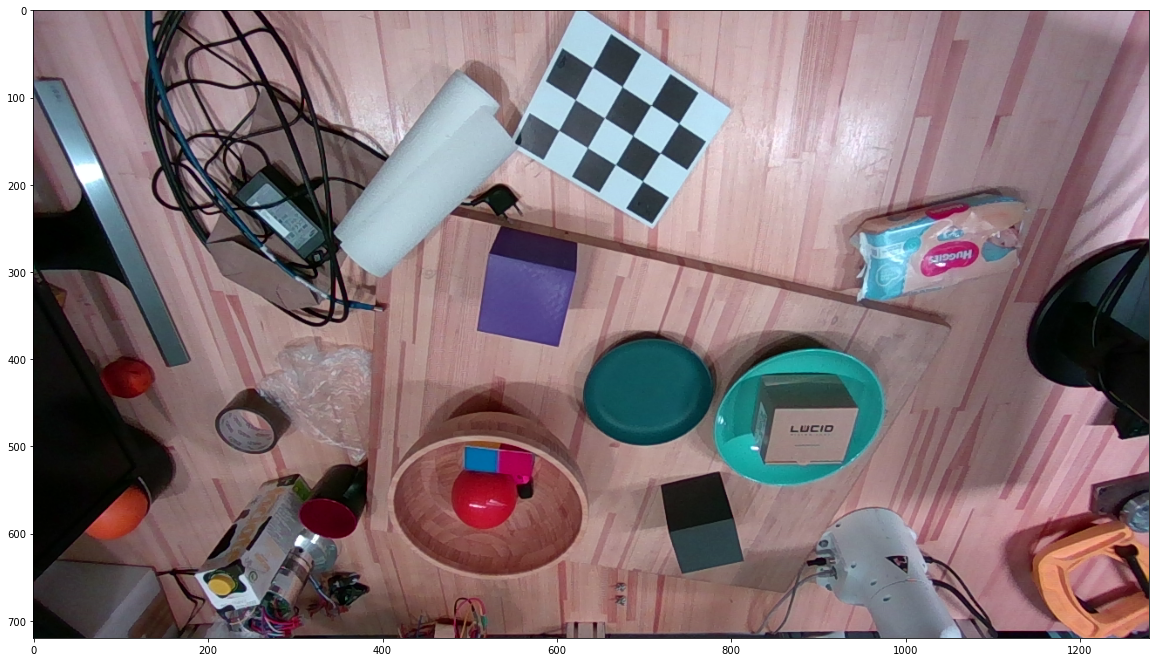

In [13]:
# Visualize single color image
plt.figure(figsize=(20, 20))
plt.imshow(data['color'][0])
plt.show()

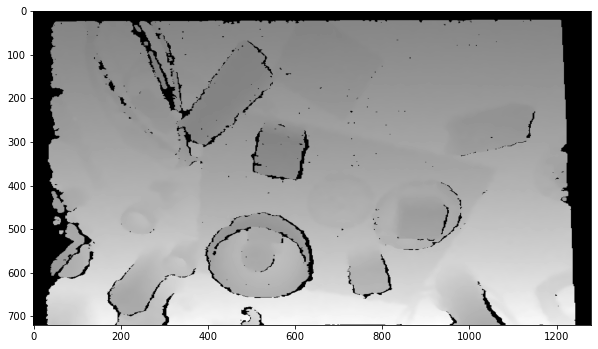

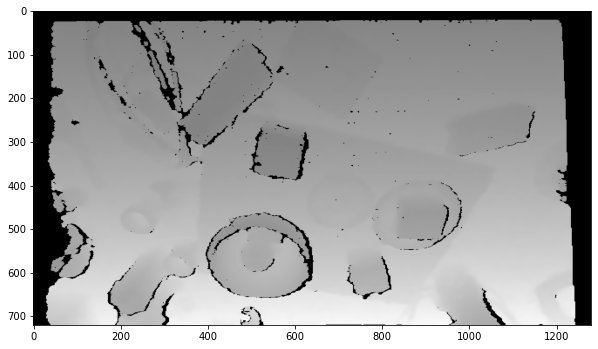

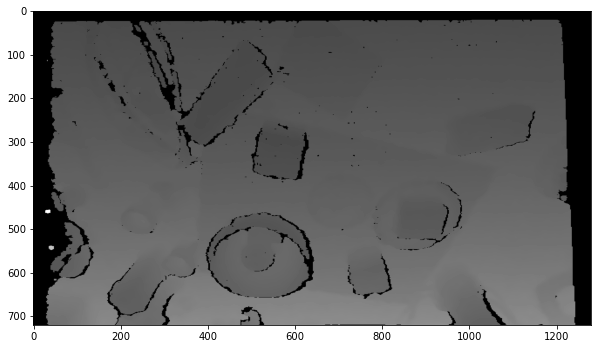

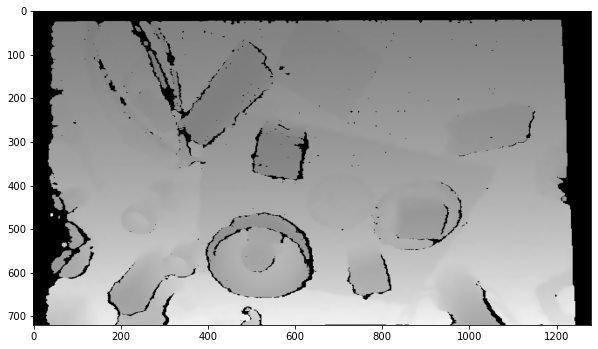

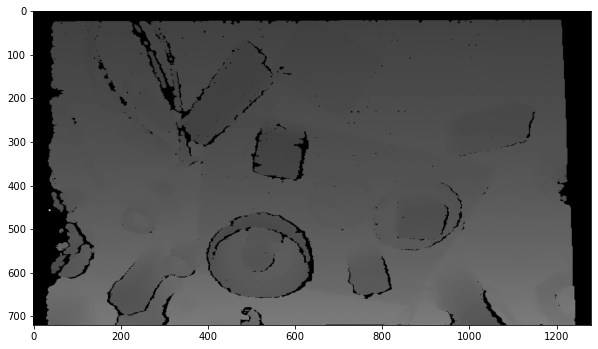

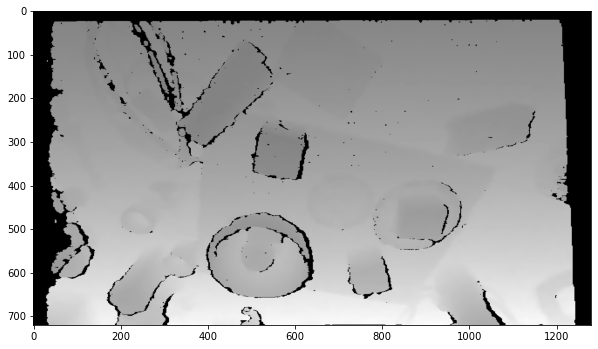

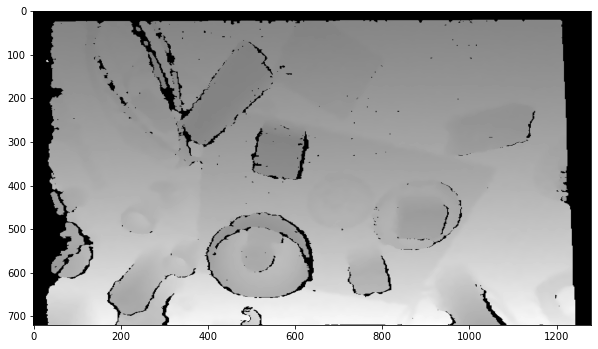

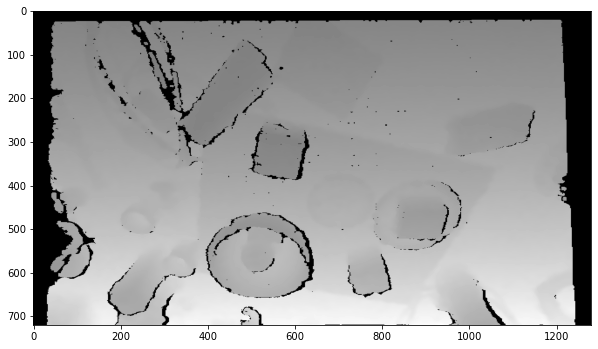

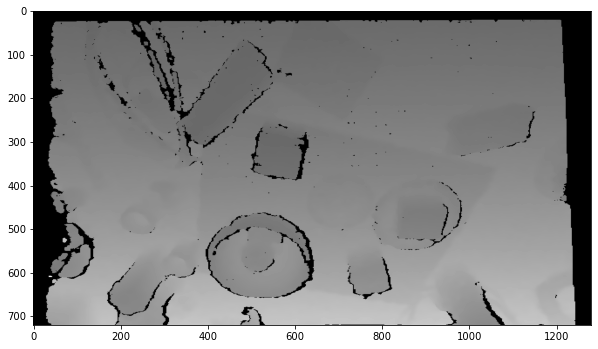

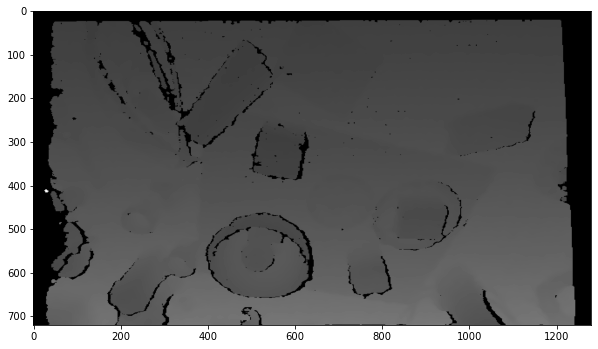

In [14]:
# Truncate depth images
for i in range(len(data['depth'])):
    data['depth'][i] = trunc_depth(data['depth'][i], 3000)
    plt.figure(figsize=(10, 10))
    plt.imshow(data['depth'][i].to_legacy_image(), cmap="gray")
    plt.show()

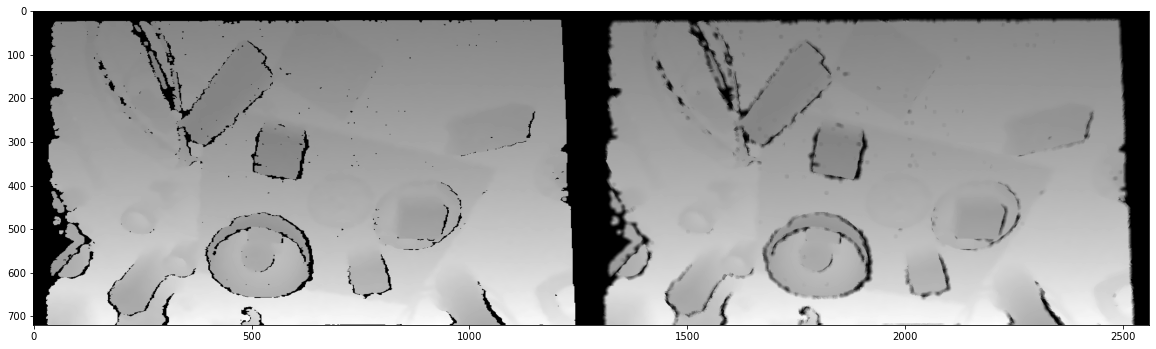

In [15]:
# Joint bilateral filter
jfd = joint_bilateral_filter(data['color'][0], data['depth'][0], 10, 15, 30)
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack((data['depth'][0].to_legacy_image(), jfd.to_legacy_image())), cmap='gray')
plt.show()

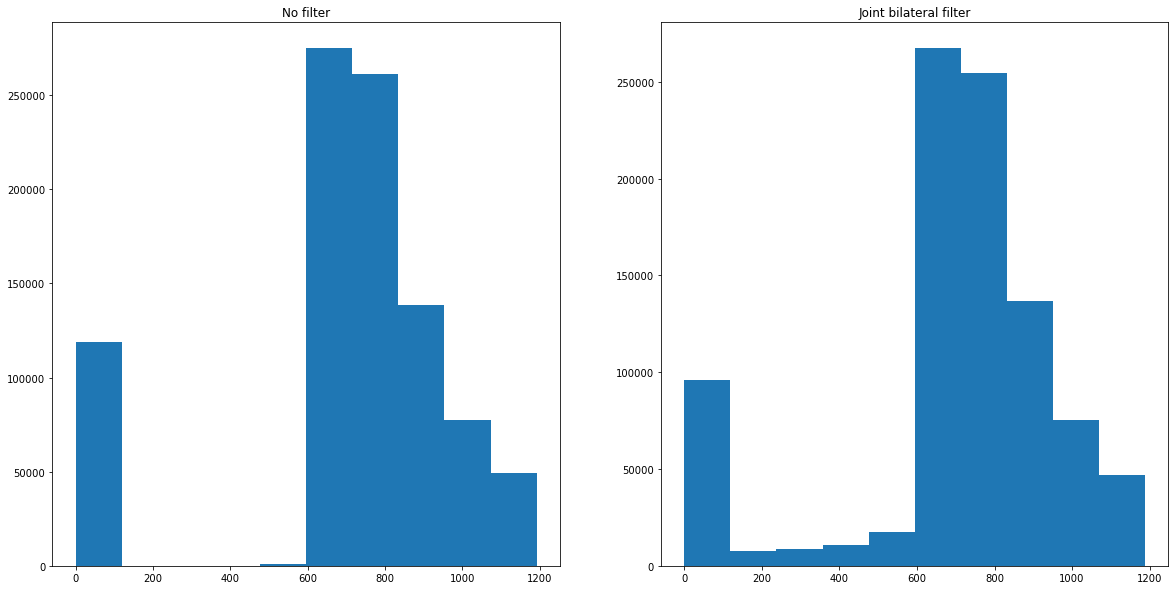

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].hist(np.asarray(data['depth'][0].to_legacy_image()).ravel())
axs[1].hist(np.asarray(jfd.to_legacy_image()).ravel())
axs[0].set_title("No filter")
axs[1].set_title("Joint bilateral filter")
plt.show()

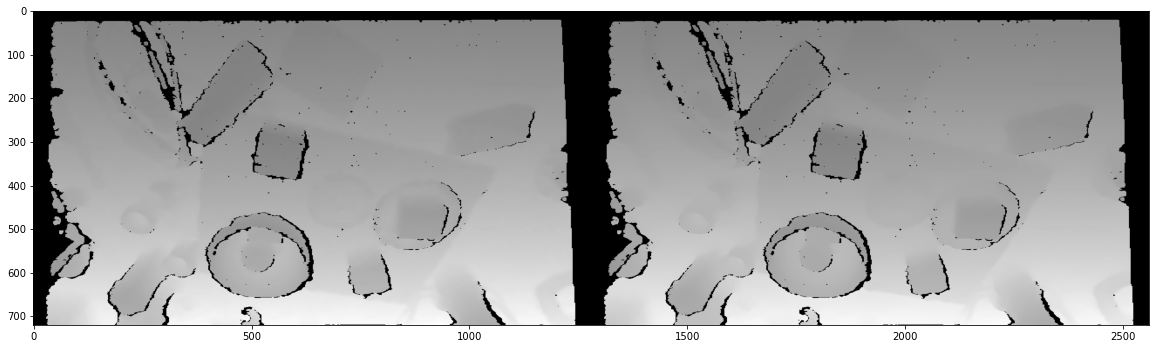

In [17]:
# Bilateral filter
bfd = bilateral_filter(data['depth'][0], 50, 15, 30)
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack((data['depth'][0].to_legacy_image(), bfd.to_legacy_image())), cmap='gray')
plt.show()

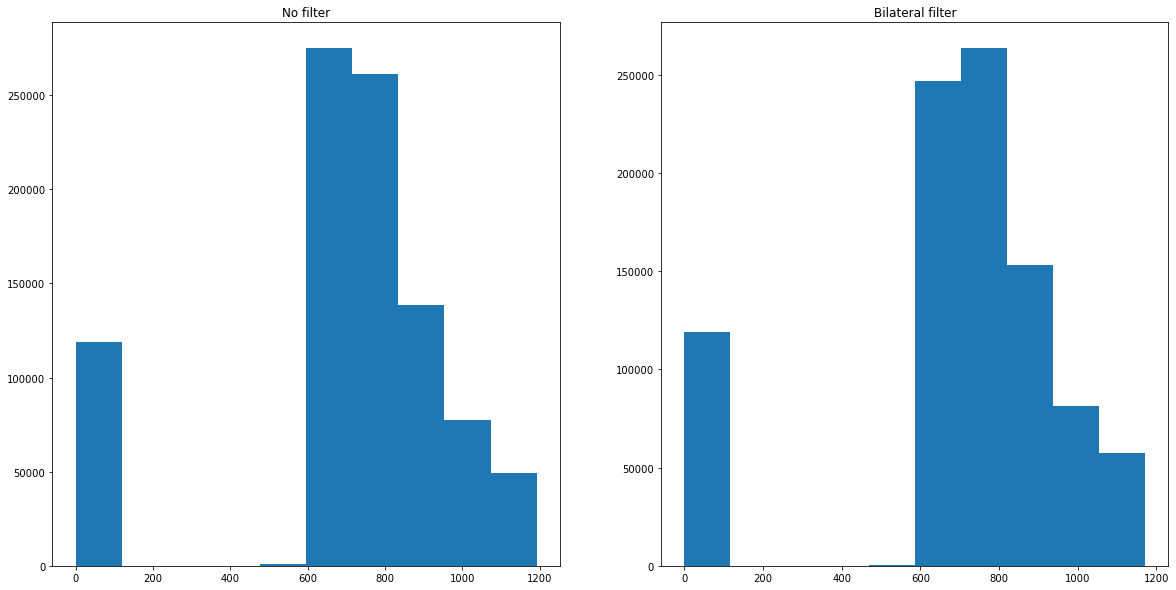

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].hist(np.asarray(data['depth'][0].to_legacy_image()).ravel())
axs[1].hist(np.asarray(bfd.to_legacy_image()).ravel())
axs[0].set_title("No filter")
axs[1].set_title("Bilateral filter")
plt.show()

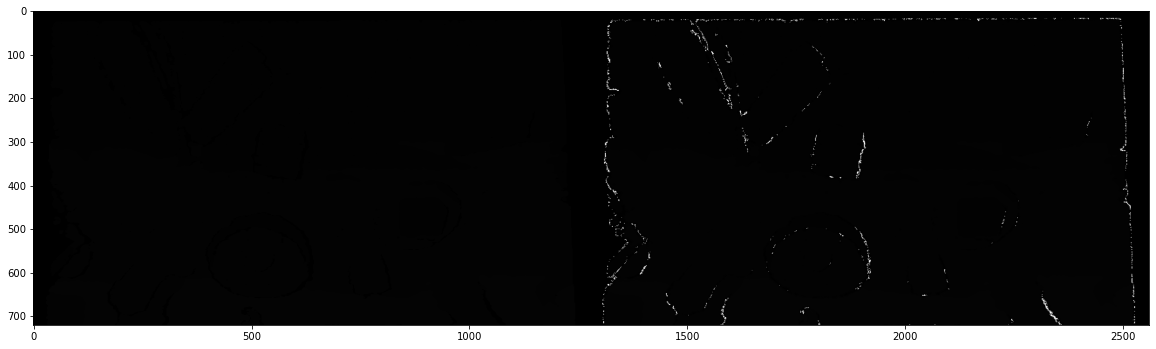

In [19]:
# Guided filter
gfd = guided_filter(data['color'][0], data['depth'][0], 2, 0.1)
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack((data['depth'][0].to_legacy_image(), gfd.to_legacy_image())), cmap='gray')
plt.show()


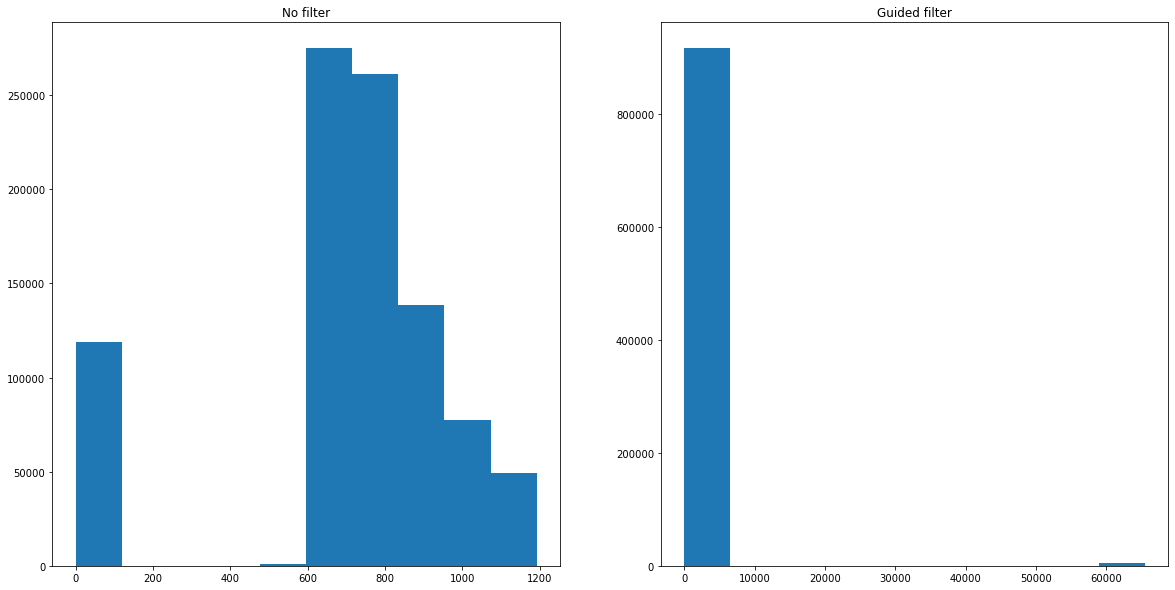

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].hist(np.asarray(data['depth'][0].to_legacy_image()).ravel())
axs[1].hist(np.asarray(gfd.to_legacy_image()).ravel())
axs[0].set_title("No filter")
axs[1].set_title("Guided filter")
plt.show()

In [21]:
point_cloud = tsdf_filter(data["color"], data["depth"], camera_information, device)

Mean compute time: 2.4431673999060877  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.


In [22]:
draw(point_cloud)

[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
FEngine (64 bits) created at 0x7f8ea0006490 (threading is enabled)
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.


Failed to establish dbus connection

WebVisualizer(window_uid='window_0')

EGL(1.5)
OpenGL(4.1)
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.08585996382865813
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.08585996382865813
[Open3D INFO] Sending init frames to window_0.


[000:000][5119] (stun_port.cc:96): Binding request timed out from 10.3.15.x:54860 (enp4s0)


In [29]:
draw(radius_outlier_removal(point_cloud, 20, 0.05))

[Open3D INFO] Window window_2 created.


WebVisualizer(window_uid='window_2')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.8511523865385504
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.8511523865385504
[Open3D INFO] Sending init frames to window_2.
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate


[094:902][5119] (stun_port.cc:96): Binding request timed out from 10.3.15.x:57231 (enp4s0)


In [27]:
draw(statistical_outlier_removal(point_cloud, 16, 0.05))

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.6022757904375065
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.6022757904375065
[Open3D INFO] Sending init frames to window_1.


# PIPELINE

#### 1. Define how many frames should be used in computing in the cell below

In [41]:
frames_no = 10

#### 2. Define desired computation hardware

In [42]:
device = o3d.core.Device("CUDA:0")
# device = o3d.core.Device("CPU:0")

#### 3. Capture stream 

In [45]:
data, camera_information = stream_camera("input/cam5_config.json", frames_no) 

Waiting 2 seconds for camera to start...[Open3D INFO] Capture started with RealSense camera 114122250435

Capturing frames
[Open3D INFO] Capture stopped.


#### 4. Truncate z-values

In [46]:
for i in range(len(data['depth'])):
    data['depth'][i] = trunc_depth(data['depth'][i], 3000)

#### 5. Choose 2D filters (Bilateral filter in this case)

In [48]:
for i in range(len(data['depth'])):
    data['depth'][i] = bilateral_filter(data['depth'][0], 10, 15, 30)


#### 6. TSDF

In [49]:
point_cloud = tsdf_filter(data["color"], data["depth"], camera_information, device)

Mean compute time: 2.423786599683808  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.


#### 7. Choose 3D filters (Radius outlier removal in this case)

In [50]:
point_cloud = radius_outlier_removal(point_cloud, 20, 0.05)

#### 8. Draw final result

In [51]:
draw(point_cloud)

[Open3D INFO] Window window_4 created.


WebVisualizer(window_uid='window_4')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.10363127644303627
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.10363127644303627
[Open3D INFO] Sending init frames to window_4.
